In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import tensorflow as tf

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import GRU
from tensorflow.keras.optimizers import SGD, Adam

import yfinance as yf
from yahoofinancials import YahooFinancials
plt.style.use('seaborn-whitegrid')

In [2]:
df = yf.download('BBRI.JK', start='2012-01-01', end='2022-05-12', progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,1360.0,1370.0,1350.0,1360.0,1013.698364,15835000
2012-01-03,1380.0,1390.0,1360.0,1380.0,1028.605713,81980000
2012-01-04,1390.0,1390.0,1370.0,1390.0,1036.059448,151180000
2012-01-05,1390.0,1400.0,1370.0,1390.0,1036.059448,134337500
2012-01-06,1380.0,1400.0,1370.0,1380.0,1028.605713,105145000
...,...,...,...,...,...,...
2022-04-27,4900.0,4930.0,4850.0,4850.0,4850.000000,191955100
2022-04-28,4870.0,4930.0,4860.0,4870.0,4870.000000,193821200
2022-05-09,4750.0,4760.0,4530.0,4530.0,4530.000000,561600400


In [3]:
df.shape

(2569, 6)

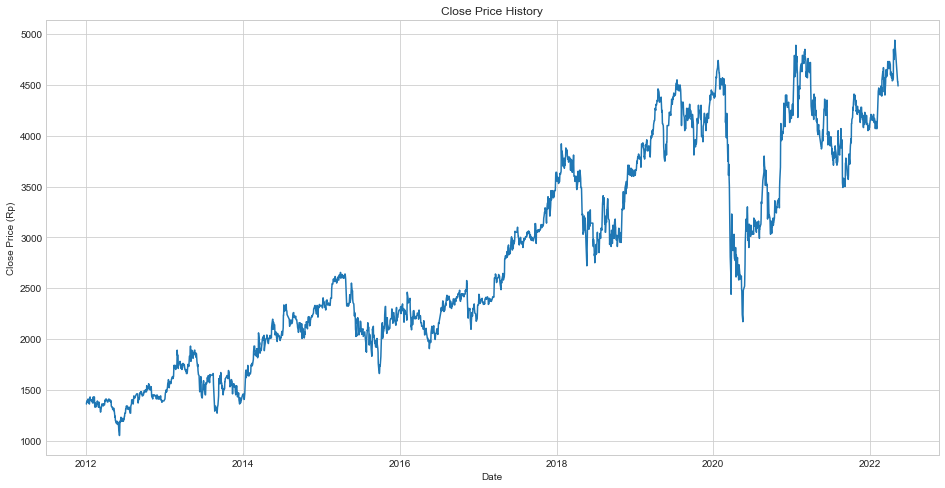

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price (Rp)')
plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2569 entries, 2012-01-02 to 2022-05-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2569 non-null   float64
 1   High       2569 non-null   float64
 2   Low        2569 non-null   float64
 3   Close      2569 non-null   float64
 4   Adj Close  2569 non-null   float64
 5   Volume     2569 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 140.5 KB


In [6]:
#create a new dataframe
data = df.filter(['Close'])

#convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .7)

training_data_len

1799

In [7]:
#normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [8]:
# building train data

train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [9]:
# building test data

test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
    
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape) 

train_data:  (1799, 1)
test_data:  (830, 1)


In [10]:
tf.keras.backend.clear_session()

regressorGRU = Sequential()

regressorGRU.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressorGRU.add(GRU(50, return_sequences=True))
regressorGRU.add(GRU(50))
regressorGRU.add(Dense(1))

print(regressorGRU.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7800      
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15150     
                                                                 
 gru_2 (GRU)                 (None, 50)                15150     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 38,151
Trainable params: 38,151
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# Compiling the RNN
regressorGRU.compile(loss='mean_squared_error', optimizer='Adam')

# Fitting to the training set
history = regressorGRU.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=32)

Epoch 1/100
55/55 [==============================] - 82s 344ms/step - loss: 0.0105 - val_loss: 0.0016
Epoch 2/100
55/55 [==============================] - 11s 204ms/step - loss: 4.1556e-04 - val_loss: 0.0015
Epoch 3/100
55/55 [==============================] - 11s 197ms/step - loss: 3.9912e-04 - val_loss: 0.0014
Epoch 4/100
55/55 [==============================] - 11s 200ms/step - loss: 3.7675e-04 - val_loss: 0.0015
Epoch 5/100
55/55 [==============================] - 11s 200ms/step - loss: 3.5735e-04 - val_loss: 0.0013
Epoch 6/100
55/55 [==============================] - 12s 226ms/step - loss: 3.4777e-04 - val_loss: 0.0012
Epoch 7/100
55/55 [==============================] - 12s 219ms/step - loss: 3.2582e-04 - val_loss: 0.0010
Epoch 8/100
55/55 [==============================] - 15s 269ms/step - loss: 3.1506e-04 - val_loss: 0.0011
Epoch 9/100
55/55 [==============================] - 14s 251ms/step - loss: 3.1984e-04 - val_loss: 8.8843e-04
Epoch 10/100
55/55 [==========================

55/55 [==============================] - 17s 307ms/step - loss: 1.6031e-04 - val_loss: 5.1951e-04
Epoch 76/100
55/55 [==============================] - 15s 282ms/step - loss: 1.5447e-04 - val_loss: 5.5874e-04
Epoch 77/100
55/55 [==============================] - 16s 300ms/step - loss: 1.6276e-04 - val_loss: 5.2657e-04
Epoch 78/100
55/55 [==============================] - 16s 294ms/step - loss: 1.5580e-04 - val_loss: 5.4440e-04
Epoch 79/100
55/55 [==============================] - 15s 280ms/step - loss: 1.5267e-04 - val_loss: 5.3749e-04
Epoch 80/100
55/55 [==============================] - 16s 298ms/step - loss: 1.6073e-04 - val_loss: 6.8750e-04
Epoch 81/100
55/55 [==============================] - 16s 295ms/step - loss: 1.5299e-04 - val_loss: 4.8938e-04
Epoch 82/100
55/55 [==============================] - 16s 282ms/step - loss: 1.6138e-04 - val_loss: 5.6735e-04
Epoch 83/100
55/55 [==============================] - 16s 287ms/step - loss: 1.8811e-04 - val_loss: 5.1505e-04
Epoch 84/100
5

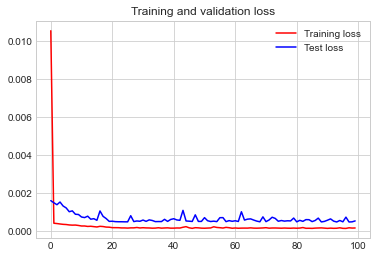

<Figure size 432x288 with 0 Axes>

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [13]:
GRU_predicted_stock_price = regressorGRU.predict(x_test)
GRU_predicted_stock_price = scaler.inverse_transform(GRU_predicted_stock_price)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

train_predicted = regressorGRU.predict(x_train)
train_predicted = scaler.inverse_transform(train_predicted)
ytrain = scaler.inverse_transform(y_train.reshape(-1,1))

C:\Users\mujah\AppData\Local\Temp\ipykernel_19976\2578014074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = GRU_predicted_stock_price


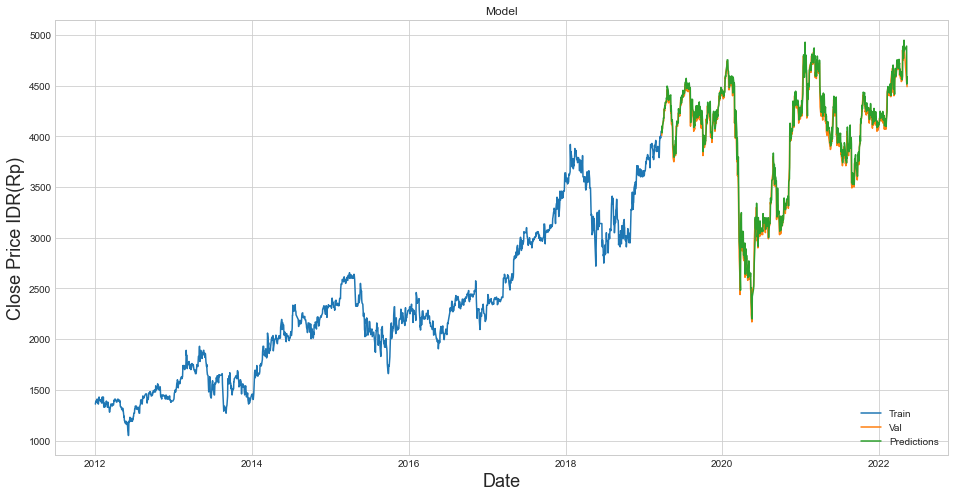

In [14]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = GRU_predicted_stock_price

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price IDR(Rp)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [15]:
print(valid.to_string())

                  Close  Predictions
Date                                
2019-03-25  4010.000000  4088.176270
2019-03-26  4060.000000  4033.303711
2019-03-27  4050.000000  4101.763672
2019-03-28  4070.000000  4075.572266
2019-03-29  4110.000000  4106.795898
2019-04-01  4150.000000  4142.820801
2019-04-02  4150.000000  4182.016602
2019-04-03  4150.000000  4177.592285
2019-04-04  4220.000000  4181.101074
2019-04-05  4270.000000  4255.856934
2019-04-08  4250.000000  4297.160645
2019-04-09  4300.000000  4273.616699
2019-04-10  4310.000000  4334.215820
2019-04-11  4300.000000  4333.256348
2019-04-12  4310.000000  4327.354004
2019-04-15  4350.000000  4339.359375
2019-04-16  4340.000000  4380.260742
2019-04-17  4340.000000  4363.565918
2019-04-18  4460.000000  4369.385742
2019-04-19  4460.000000  4495.549316
2019-04-22  4440.000000  4474.112793
2019-04-23  4430.000000  4464.906250
2019-04-24  4400.000000  4454.379395
2019-04-25  4330.000000  4424.388184
2019-04-26  4330.000000  4354.665039
2

In [16]:
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,GRU_predicted_stock_price)))
print("Test data MSE: ", mean_squared_error(y_test,GRU_predicted_stock_price))
print("Test data MAE: ", mean_absolute_error(y_test,GRU_predicted_stock_price))
print("Test data MAPE: ", mean_absolute_percentage_error(y_test,GRU_predicted_stock_price))
print("Test data R2 score:", r2_score(y_test,GRU_predicted_stock_price))

Test data RMSE:  90.20552470403376
Test data MSE:  8137.036687130046
Test data MAE:  67.06158336292614
Test data MAPE:  0.01766225506222884
Test data R2 score: 0.9731412674323717


In [17]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(ytrain,train_predicted)))
print("Train data MSE: ", mean_squared_error(ytrain,train_predicted))
print("Train data MAE: ", mean_absolute_error(ytrain,train_predicted))
print("Test data R2 score:", r2_score(ytrain,train_predicted))

Train data RMSE:  49.901604093786716
Train data MSE:  2490.1700911330313
Train data MAE:  36.55013559000324
Test data R2 score: 0.9951180176242305


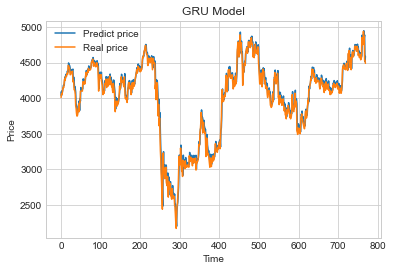

In [18]:
plt.plot(GRU_predicted_stock_price, label="Predict price")
plt.plot(y_test, label="Real price")

plt.title("GRU Model") 
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()